In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import random
import cv2
import numpy as np
import splitfolders
from patchify import patchify
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
patch_size = 256
root_dir = '/content/drive/MyDrive/1_2_Akshay/satellite_data'

In [ ]:

def find_labels():
    labels = []
    for path, sub, files in os.walk(root_dir):
        dir = path.split(os.path.sep)[-1]
        if dir == 'masks':
            masks = os.listdir(path)
            for i, msk_num in enumerate(masks):
                msk = cv2.imread(path + "/" + msk_num, 1)
                label = np.unique(msk[:, :, 1])
                for la in label:
                    if la not in labels:
                        labels.append(la)
    labels = np.sort(labels)
    print('labels:', labels)
    print('number of classes:', len(labels))

find_labels()

labels: [  0  16  41 155 169 193 221]
number of classes: 7


In [ ]:
def make_directories():
    try:
        os.makedirs('/content/drive/MyDrive/Workplace/models', exist_ok=True)
        os.makedirs('/content/drive/MyDrive/Workplace/output', exist_ok=True)
        os.makedirs('{}/patches/images'.format(root_dir), exist_ok=True)
        os.makedirs('{}/patches/masks'.format(root_dir), exist_ok=True)
        os.makedirs('{}/data/training_data/train_images/train'.format(root_dir), exist_ok=True)
        os.makedirs('{}/data/training_data/train_masks/train'.format(root_dir), exist_ok=True)
        os.makedirs('{}/data/training_data/val_images/val'.format(root_dir), exist_ok=True)
        os.makedirs('{}/data/training_data/val_masks/val'.format(root_dir), exist_ok=True)
        print("All Directories are created successfully..")
    except OSError as error:
        print("Directory can not be created")

make_directories()

All Directories are created successfully..


In [ ]:
def make_class_satellite(mask):

    mask_g = mask[:, :, 1].copy()
    mask_g[mask_g == 41] = 1    # land
    mask_g[mask_g == 16] = 2    # building
    mask_g[mask_g == 193] = 3   # road
    mask_g[mask_g == 221] = 4   # vegetation
    mask_g[mask_g == 169] = 5   # water
    mask_g[mask_g == 155] = 0   # unlabeled
    return mask_g


**Patchiification of Imagees**

In [ ]:
def patch_image(patch_size):
    count = 0
    for path, sub, files in os.walk(root_dir):
        dir = path.split(os.path.sep)[-1]
        if dir == 'images':
            images = os.listdir(path)
            for k, image_name in enumerate(images):
                if image_name.endswith(".jpg") or image_name.endswith(".png"):
                    image = cv2.imread(path + "/" + image_name, 1)
                    wd = (image.shape[1] // patch_size) * patch_size
                    ht = (image.shape[0] // patch_size) * patch_size
                    image = Image.fromarray(image)
                    image = image.crop((0, 0, wd, ht))
                    image = np.array(image, dtype='uint8')
                    print("Patchifying image:", path + "/" + image_name)
                    patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
                    for i in range(patches_img.shape[0]):
                        for j in range(patches_img.shape[1]):
                            single_patch_img = patches_img[i, j, :, :]
                            cv2.imwrite('{}/patches/images/{}.jpg'.format(root_dir, count),
                                        single_patch_img[0])
                            count = count+1


patch_image(patch_size)

Patchifying image: /content/drive/MyDrive/Workplace/satellite_data/Tile 7/images/image_part_001.jpg
Patchifying image: /content/drive/MyDrive/Workplace/satellite_data/Tile 7/images/image_part_002.jpg
Patchifying image: /content/drive/MyDrive/Workplace/satellite_data/Tile 7/images/image_part_007.jpg
Patchifying image: /content/drive/MyDrive/Workplace/satellite_data/Tile 7/images/image_part_005.jpg
Patchifying image: /content/drive/MyDrive/Workplace/satellite_data/Tile 7/images/image_part_009.jpg
Patchifying image: /content/drive/MyDrive/Workplace/satellite_data/Tile 7/images/image_part_006.jpg
Patchifying image: /content/drive/MyDrive/Workplace/satellite_data/Tile 7/images/image_part_004.jpg
Patchifying image: /content/drive/MyDrive/Workplace/satellite_data/Tile 7/images/image_part_008.jpg
Patchifying image: /content/drive/MyDrive/Workplace/satellite_data/Tile 7/images/image_part_003.jpg
Patchifying image: /content/drive/MyDrive/Workplace/satellite_data/Tile 3/images/image_part_001.jpg


**Patchification of Mask**

In [ ]:
def patch_mask(patch_size):
    count = 0
    for path, sub, files in os.walk(root_dir):
        dir = path.split(os.path.sep)[-1]
        if dir == 'masks':
            masks = os.listdir(path)
            for k, mask_name in enumerate(masks):
                if mask_name.endswith(".png") or mask_name.endswith(".jpg"):
                    mask = cv2.imread(path + "/" + mask_name, 1)
                    wd = (mask.shape[1] // patch_size) * patch_size
                    ht = (mask.shape[0] // patch_size) * patch_size
                    mask = Image.fromarray(mask)
                    mask = mask.crop((0, 0, wd, ht))
                    mask = np.array(mask, dtype='uint8')
                    print("Patchifying mask:", path + "/" + mask_name)
                    patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)
                    for i in range(patches_mask.shape[0]):
                        for j in range(patches_mask.shape[1]):
                            patch_mask = patches_mask[i, j, :, :]
                            patch_mask = patch_mask[0]  # Drop extra dimension
                            patch_mask = make_class_satellite(patch_mask)
                            cv2.imwrite('{}/patches/masks/{}.png'.format(root_dir, count), patch_mask)
                            count = count+1


patch_mask(patch_size)

Patchifying mask: /content/drive/MyDrive/Workplace/satellite_data/Tile 7/masks/image_part_004.png
Patchifying mask: /content/drive/MyDrive/Workplace/satellite_data/Tile 7/masks/image_part_006.png
Patchifying mask: /content/drive/MyDrive/Workplace/satellite_data/Tile 7/masks/image_part_001.png
Patchifying mask: /content/drive/MyDrive/Workplace/satellite_data/Tile 7/masks/image_part_005.png
Patchifying mask: /content/drive/MyDrive/Workplace/satellite_data/Tile 7/masks/image_part_009.png
Patchifying mask: /content/drive/MyDrive/Workplace/satellite_data/Tile 7/masks/image_part_008.png
Patchifying mask: /content/drive/MyDrive/Workplace/satellite_data/Tile 7/masks/image_part_007.png
Patchifying mask: /content/drive/MyDrive/Workplace/satellite_data/Tile 7/masks/image_part_003.png
Patchifying mask: /content/drive/MyDrive/Workplace/satellite_data/Tile 7/masks/image_part_002.png
Patchifying mask: /content/drive/MyDrive/Workplace/satellite_data/Tile 3/masks/image_part_003.png
Patchifying mask: /c

In [ ]:
def find_labels_after_patches():
    path = '{}/patches/masks/'.format(root_dir)
    mask_list = os.listdir(path)
    labels = []
    for m in mask_list:
        msk = cv2.imread(os.path.join(path, m), 0)
        label = np.unique(msk)
        for l in label:
            if l not in labels:
                labels.append(l)
    labels = np.sort(labels)
    print('labels:', labels)
    print('number of classes:', len(labels))
    return len(labels), labels

n_class, labels = find_labels_after_patches()

labels: [0 1 2 3 4 5]
number of classes: 6


**Outlier Removel**

In [ ]:
class outliers:
    def __init__(self):
        pass

    def clean_outliers(self):
        os.makedirs('{}/useful/images'.format(root_dir), exist_ok=True)
        os.makedirs('{}/useful/masks'.format(root_dir), exist_ok=True)
        img_list = os.listdir('{}/patches/images/'.format(root_dir))
        msk_list = os.listdir('{}/patches/masks/'.format(root_dir))
        useless = 0

        for i in range(len(img_list)):
            img_name = img_list[i]
            mask_name = msk_list[i]
            temp_image = cv2.imread('{}/patches/images/{}'.format(root_dir, img_name), 1)
            temp_mask = cv2.imread('{}/patches/masks/{}'.format(root_dir, mask_name), 0)

            val, counts = np.unique(temp_mask, return_counts=True)

            if (1 - (counts[0] / counts.sum())) > 0.05:
                cv2.imwrite('{}/useful/images/{}'.format(root_dir, img_name), temp_image)
                cv2.imwrite('{}/useful/masks/{}'.format(root_dir, mask_name), temp_mask)
            else:
                useless += 1

        print("Total useful images are: ", len(img_list) - useless)
        print("Total useless images are: ", useless)


o = outliers()
o.clean_outliers()

Total useful images are:  1037
Total useless images are:  268


**Training and Testing Data Split**

In [ ]:
def split_data():
    splitfolders.ratio(input='{}/patches/'.format(root_dir),
                       output='{}/data/training_and_testing/'.format(root_dir),
                       seed=42, ratio=(.9, .1), group_prefix=None)
    print('train data & validation data saved in "data/training_and_testing" Folder..')

split_data()

Copying files: 5220 files [00:48, 107.61 files/s]

train data & validation data saved in "data/training_and_testing" Folder..


In [ ]:
def move_train_data():
    train_images = "{}/data/training_and_testing/train/images".format(root_dir)
    target_train_images = "{}/data/training_data/train_images/train".format(root_dir)
    train_masks = "{}/data/training_and_testing/train/masks".format(root_dir)
    target_train_masks = "{}/data/training_data/train_masks/train".format(root_dir)
    for img, msk in zip(os.listdir(train_images), os.listdir(train_masks)):
        image = cv2.imread(os.path.join(train_images, img), 1)
        cv2.imwrite(target_train_images + '/'+img, image)
        mask = cv2.imread(os.path.join(train_masks, msk), 0)
        cv2.imwrite(target_train_masks + '/' + msk, mask)
    print('training data moved...')

move_train_data()

training data moved...


In [ ]:
def move_validation_data():
    val_images = "{}/data/training_and_testing/val/images".format(root_dir)
    target_val_images = "{}/data/training_data/val_images/val".format(root_dir)
    val_masks = "{}/data/training_and_testing/val/masks".format(root_dir)
    target_val_masks = "{}/data/training_data/val_masks/val".format(root_dir)
    for img, msk in zip(os.listdir(val_images), os.listdir(val_masks)):
        image = cv2.imread(os.path.join(val_images, img), 1)
        cv2.imwrite(target_val_images + '/'+img, image)
        mask = cv2.imread(os.path.join(val_masks, msk), 0)
        cv2.imwrite(target_val_masks + '/' + msk, mask)
    print('validation data moved...')

move_validation_data()

validation data moved...


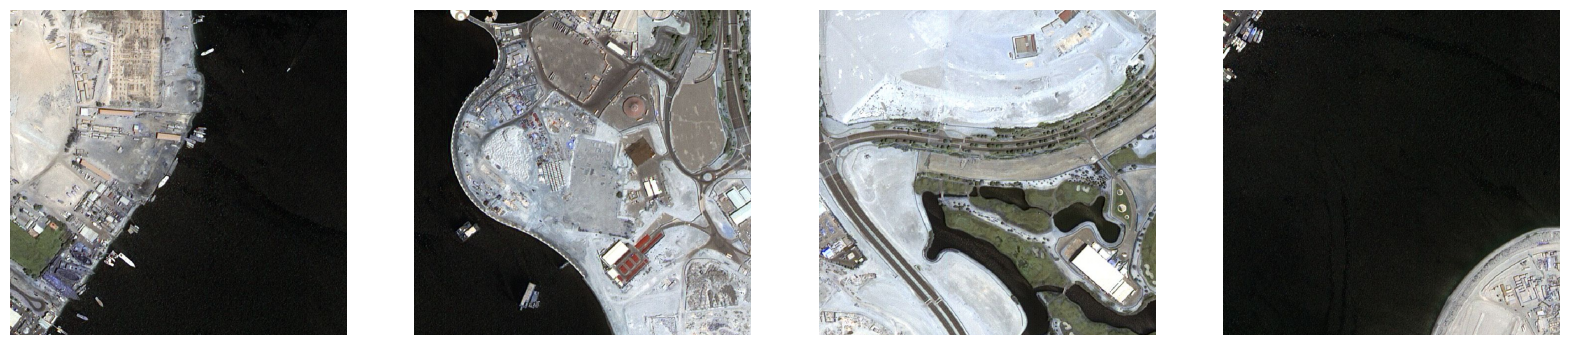

In [ ]:
import matplotlib.pyplot as plt
def show_images():
    image_count = 0
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    for path, sub, files in os.walk(root_dir):
        dir = path.split(os.path.sep)[-1]
        if dir == 'images':
            images = sorted(os.listdir(path))
            for img in images:
                img_path = os.path.join(path, img)
                img = cv2.imread(img_path, 1)
                ht, wd = img.shape[:2]
                img = cv2.resize(img, (720*wd//ht, 720), interpolation=cv2.INTER_NEAREST)

                axs[image_count].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                axs[image_count].axis('off')

                image_count += 1
                if image_count == 4:
                    plt.show()
                    image_count = 0
                    break

    if image_count > 0:
        plt.show()

show_images()


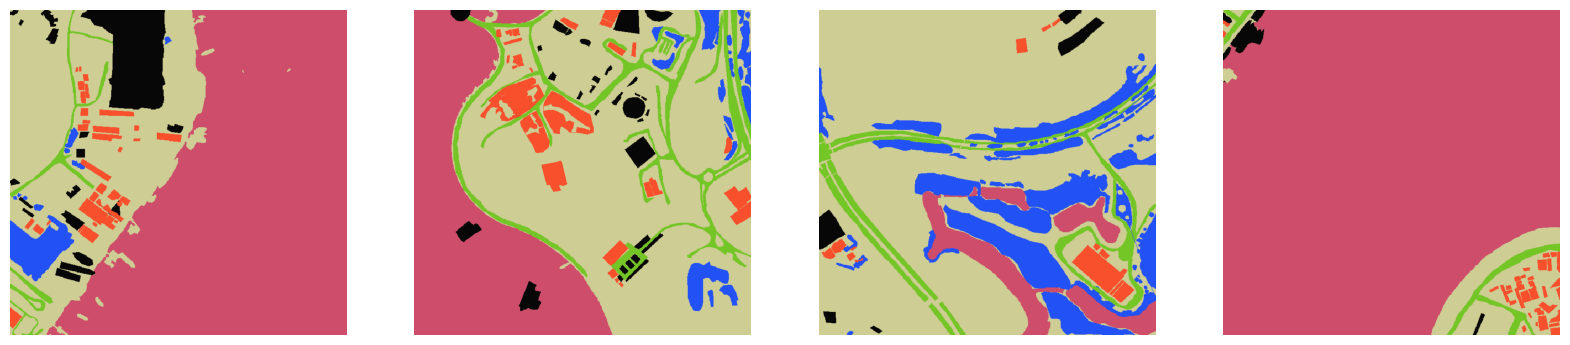

In [ ]:
import matplotlib.pyplot as plt

def show_masks():
    mask_count = 0
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    for path, sub, files in os.walk(root_dir):
        dir = path.split(os.path.sep)[-1]
        if dir == 'masks':
            masks = sorted(os.listdir(path))
            for msk in masks:
                msk_path = os.path.join(path, msk)
                msk = cv2.imread(msk_path, 1)
                ht, wd = msk.shape[:2]
                msk = cv2.resize(msk, (720*wd//ht, 720), interpolation=cv2.INTER_NEAREST)

                axs[mask_count].imshow(msk * 5)
                axs[mask_count].axis('off')

                mask_count += 1
                if mask_count == 4:
                    plt.show()
                    mask_count = 0
                    break

    if mask_count > 0:
        plt.show()



show_masks()


In [ ]:
def draw_patches():
    mask_path = '{}/data/training_and_testing/train/masks'.format(root_dir)
    mask_lst = sorted(os.listdir(mask_path))
    num = random.randint(0, len(mask_lst))
    img_path = '{}/data/training_and_testing/train/images'.format(root_dir)
    img_lst = sorted(os.listdir(img_path))
    mask = cv2.imread(os.path.join(mask_path, mask_lst[num]), 0)
    image = cv2.imread(os.path.join(img_path, img_lst[num]), 1)
    plt.figure(figsize=(16, 10))
    plt.subplot(121)
    plt.imshow(image)
    plt.title('Image-Patch')
    plt.subplot(122)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask-Patch')
    plt.imshow(mask)
    plt.show()


def data_size():
    return patch_size

def root_directory():
    return root_dir

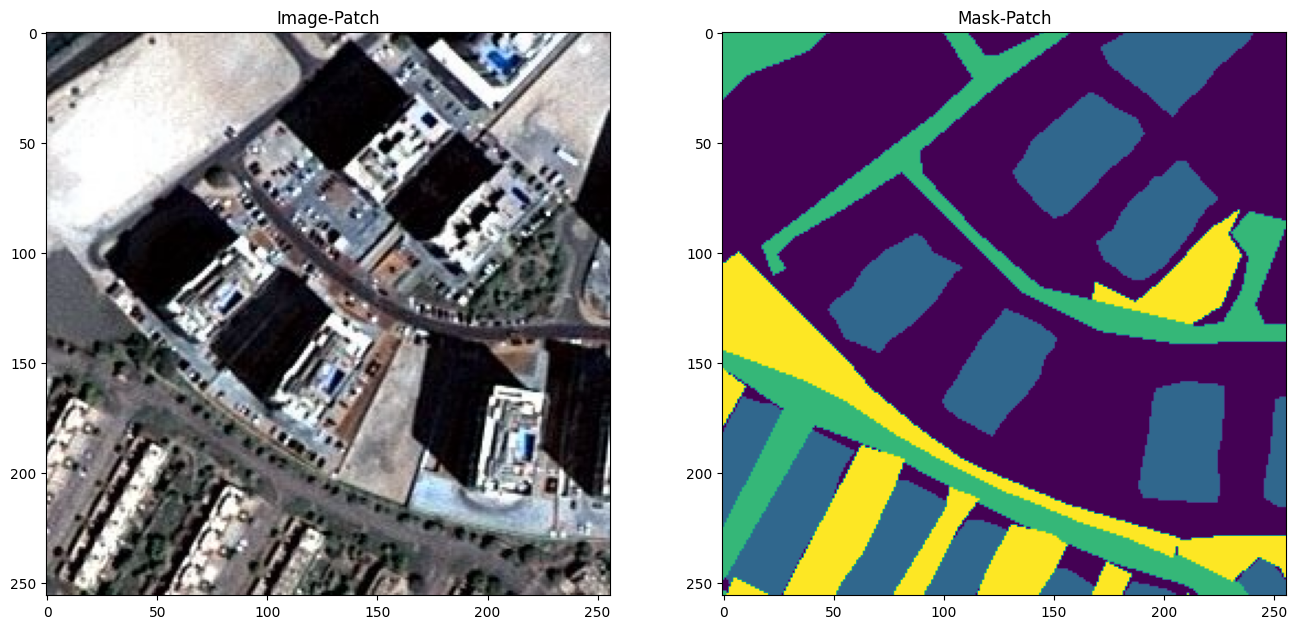

In [ ]:
draw_patches()

**Data Preprocess**

In [ ]:
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [ ]:
seed = 200
n_class, _ = find_labels_after_patches()
patch_size = data_size()

labels: [0 1 2 3 4 5]
number of classes: 6


In [ ]:
def preprocess_data(img, mask, n_class):
    img = (img.reshape(-1, img.shape[-1])).reshape(img.shape)/255.0
    mask = to_categorical(mask, n_class)

    return img, mask


def trainGenerator(train_img_path, train_mask_path, batch_size=4, img_size=patch_size, n_class=n_class):
    img_data_gen_args = dict(horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='reflect')

    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode=None,
        target_size=(img_size, img_size),
        color_mode='rgb',
        batch_size=batch_size,
        seed=seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode=None,
        target_size=(img_size, img_size),
        color_mode='grayscale',
        batch_size=batch_size,
        seed=seed)

    train_generator = zip(image_generator, mask_generator)

    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, n_class=n_class)
        yield img, mask


def plot_history(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    plt.plot(epochs, acc, 'y', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()
    plt.show()


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler
from tensorflow import keras

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.0001, 60)

lr_scheduler = LearningRateScheduler(
    exponential_decay_fn,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath = '/content/drive/MyDrive/1_2_Akshay/Satellite_Image_Segmentation_Model.hdf5',
    save_best_only = True,
    monitor = 'val_loss',
    mode = 'auto',
    verbose = 1
)

earlystop = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.001,
    patience = 12,
    mode = 'auto',
    verbose = 1,
    restore_best_weights = True
)

csvlogger = CSVLogger(
    filename= "/content/drive/MyDrive/1_2_Akshay/model_training_simple_UNet.csv",
    separator = ",",
    append = False
)

callbacks = [
             checkpoint,
             earlystop,
             csvlogger,
             lr_scheduler,
             keras.callbacks.ModelCheckpoint(
                os.path.join("/content/drive/MyDrive/1_2_Akshay/weights", "weights.02-data-aug.{epoch:03d}.hdf5"),
                save_best_only=False,
                save_weights_only=True
              ),
            ]

**Simple U-Net**

In [ ]:
def simple_unet_model(size=(256, 256, 3), n_class=3):
    s = Input(size)
    # Contraction
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.30)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.30)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.30)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.30)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    # bottleneck
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.30)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    # Extraction
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.30)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.30)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.30)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.30)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    outputs = Conv2D(n_class, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[s], outputs=[outputs])

    return model



In [ ]:
import tensorflow as tf
import os

size = data_size()
batch_size = 16
n_class, labels = find_labels_after_patches()


model_path = '/content/drive/MyDrive/1_2_Akshay/models/Satellite_Image_Segmentation_Simple_UNet_Model.hdf5'


class Training:
    def __init__(self, n_class, model_path, root_dir, batch_size, size):
        self.batch_size = batch_size
        self.n_class = n_class
        self.model_path = model_path
        self.directory = root_dir
        self.size = size
        self.train_img_path = "/content/drive/MyDrive/1_2_Akshay/satellite_data/data/training_data/train_images/".format(self.directory)
        self.train_mask_path = "/content/drive/MyDrive/1_2_Akshay/satellite_data/data/training_data/train_masks/".format(self.directory)
        self.val_img_path = "/content/drive/MyDrive/1_2_Akshay/satellite_data/data/training_data/val_images/".format(self.directory)
        self.val_mask_path = "/content/drive/MyDrive/1_2_Akshay/satellite_data/data/training_data/val_masks/".format(self.directory)
        self.train_img_gen = trainGenerator(self.train_img_path, self.train_mask_path,
                                            batch_size=self.batch_size, img_size=self.size, n_class=self.n_class)
        self.val_img_gen = trainGenerator(self.val_img_path, self.val_mask_path,
                                          batch_size=self.batch_size, img_size=self.size, n_class=self.n_class)
        self.num_train_imgs = len(sorted(os.listdir(os.path.join(self.train_img_path, 'train'))))
        self.num_val_imgs = len(sorted(os.listdir('/content/drive/MyDrive/1_2_Akshay/satellite_data/data/training_data/val_images/val/'.format(self.directory))))
        self.steps_per_epoch = self.num_train_imgs // self.batch_size
        self.val_steps_per_epoch = self.num_val_imgs // self.batch_size

    def print_gen(self):
        print('No. of train images     :', self.num_train_imgs)
        print('No. of validation images:', self.num_val_imgs)
        print('training steps per epoch:', self.steps_per_epoch)
        print('validation steps per epoch:', self.val_steps_per_epoch)

    def model_save(self):
        mod = simple_unet_model(size=(self.size, self.size, 3), n_class=self.n_class)
        mod.save(self.model_path)
        print('model saved at....:{}'.format(self.model_path))

    def train(self, epochs=10, lr=2e-4, callbacks=callbacks, training_type='saved_model'):
        if training_type == 'saved_model':
            model = tf.keras.models.load_model(self.model_path, compile=True)
            print('saved model loaded..')
        elif training_type == 'new_model':
            self.model_save()
            model = tf.keras.models.load_model(self.model_path, compile=True)
            print('new model loaded...')

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                      loss='categorical_crossentropy', metrics='accuracy')

        model.summary()

        hist = model.fit(self.train_img_gen, steps_per_epoch=self.steps_per_epoch,
                         epochs=epochs,
                         callbacks=callbacks,
                         verbose=1, validation_data=self.val_img_gen,
                         validation_steps=self.val_steps_per_epoch)
        model.save(self.model_path)
        print('model trained and saved..')
        return hist


train = Training(model_path=model_path, root_dir=root_dir, n_class=n_class, batch_size=batch_size, size=size)
train.print_gen()
"""
for new data/model write 'new_model'
"""
hist = train.train(epochs=50, lr = 0.0001, callbacks=callbacks, training_type='new_model')



labels: [0 1 2 3 4 5]
number of classes: 6
No. of train images     : 1174
No. of validation images: 131
training steps per epoch: 73
validation steps per epoch: 8


model saved at....:/content/drive/MyDrive/1_2_Akshay/models/Satellite_Image_Segmentation_Simple_UNet_Model.hdf5


new model loaded...
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 256, 256, 16  448         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_36 (Dropout)           (None, 256, 256, 16  0           ['conv2d_76[0][0]']              
                                )                                       

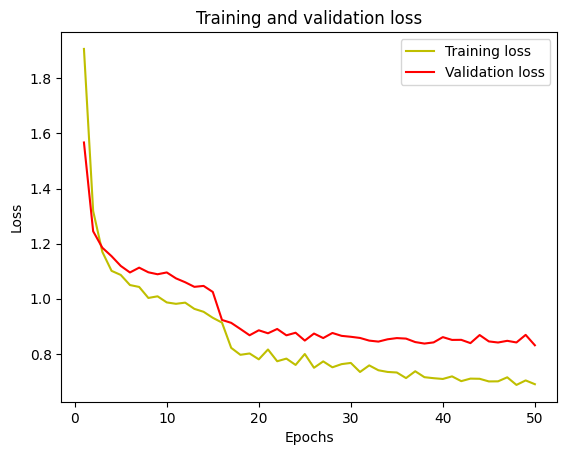

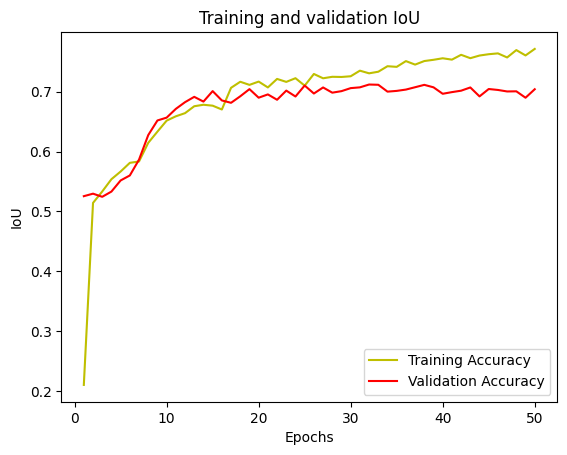

In [ ]:
plot_history(hist)

1/1 [==============================] - 2s 2s/step


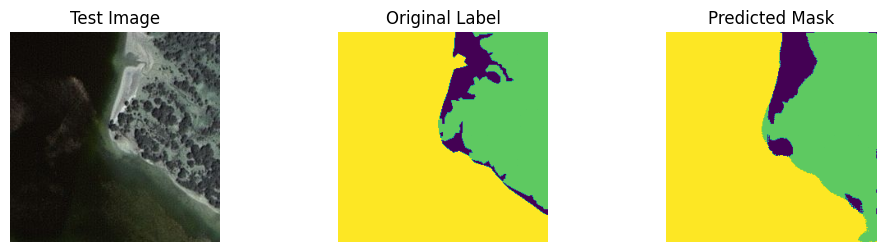

In [ ]:
from keras.models import load_model
import os
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt
root_dir = '/content/drive/MyDrive/1_2_Akshay/satellite_data'


model = load_model('/content/drive/MyDrive/1_2_Akshay/models/Satellite_Image_Segmentation_Simple_UNet_Model.hdf5', compile=False)
test_img_dir = "{}/data/training_data/train_images/train/".format(root_dir)
test_mask_dir = "{}/data/training_data/train_masks/train/".format(root_dir)
imgLst = sorted(os.listdir(test_img_dir))
mskLst = sorted(os.listdir(test_mask_dir))
img_number = random.randint(0, len(imgLst))


def random_prediction():
    ground_truth = cv2.imread(test_mask_dir + '{}'.format(mskLst[img_number]), 0)
    image = cv2.imread(test_img_dir + '{}'.format(imgLst[img_number]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    test_img = (image.reshape(-1, image.shape[-1])).reshape(image.shape)/255.0
    test_img_input = np.expand_dims(test_img, 0)
    prediction = model.predict(test_img_input)
    predicted_img = np.argmax(prediction, axis=3)[0, :, :]
    plt.figure(figsize=(12, 6))

    plt.subplot(231)
    plt.imshow(test_img)
    plt.title('Test Image')
    plt.axis('off')

    plt.subplot(232)
    plt.imshow(ground_truth)
    plt.title('Original Label')
    plt.axis('off')

    plt.subplot(233)
    plt.imshow(predicted_img)
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.show()


random_prediction()

**Multi UNet Model**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler
from tensorflow import keras

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.0001, 60)

lr_scheduler = LearningRateScheduler(
    exponential_decay_fn,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath = '/content/drive/MyDrive/1_2_Akshay/Satellite_Image_Segmentation_Multi_UNet_Model.hdf5',
    save_best_only = True,
#     save_weights_only = False,
    monitor = 'val_loss',
    mode = 'auto',
    verbose = 1
)

earlystop = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.001,
    patience = 12,
    mode = 'auto',
    verbose = 1,
    restore_best_weights = True
)

csvlogger = CSVLogger(
    filename= "/content/drive/MyDrive/1_2_Akshay/model_training_Multi_UNet.csv",
    separator = ",",
    append = False
)

callbacks = [
             checkpoint,
             earlystop,
             csvlogger,
             lr_scheduler,
             keras.callbacks.ModelCheckpoint(
                os.path.join("/content/drive/MyDrive/1_2_Akshay/weights", "weights_2.02-data-aug.{epoch:03d}.hdf5"),
                save_best_only=False,
                save_weights_only=True
              ),
            ]

In [ ]:
def multi_unet_model(size=(256, 256, 3), n_class=3):
    s = Input(size, dtype=tf.float32)
    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.25)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.25)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.25)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.25)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.25)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.25)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.25)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.25)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.25)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_class, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[s], outputs=[outputs])

    return model


In [ ]:
import tensorflow as tf
import os

size = data_size()
batch_size = 16
n_class, labels = find_labels_after_patches()


model_path = '/content/drive/MyDrive/1_2_Akshay/models/Satellite_Image_Segmentation_Multi_UNet_Model.hdf5'


class Training:
    def __init__(self, n_class, model_path, root_dir, batch_size, size):
        self.batch_size = batch_size
        self.n_class = n_class
        self.model_path = model_path
        self.directory = root_dir
        self.size = size
        self.train_img_path = "/content/drive/MyDrive/1_2_Akshay/satellite_data/data/training_data/train_images/".format(self.directory)
        self.train_mask_path = "/content/drive/MyDrive/1_2_Akshay/satellite_data/data/training_data/train_masks/".format(self.directory)
        self.val_img_path = "/content/drive/MyDrive/1_2_Akshay/satellite_data/data/training_data/val_images/".format(self.directory)
        self.val_mask_path = "/content/drive/MyDrive/1_2_Akshay/satellite_data/data/training_data/val_masks/".format(self.directory)
        self.train_img_gen = trainGenerator(self.train_img_path, self.train_mask_path,
                                            batch_size=self.batch_size, img_size=self.size, n_class=self.n_class)
        self.val_img_gen = trainGenerator(self.val_img_path, self.val_mask_path,
                                          batch_size=self.batch_size, img_size=self.size, n_class=self.n_class)
        self.num_train_imgs = len(sorted(os.listdir(os.path.join(self.train_img_path, 'train'))))
        self.num_val_imgs = len(sorted(os.listdir('/content/drive/MyDrive/1_2_Akshay/satellite_data/data/training_data/val_images/val/'.format(self.directory))))
        self.steps_per_epoch = self.num_train_imgs // self.batch_size
        self.val_steps_per_epoch = self.num_val_imgs // self.batch_size

    def print_gen(self):
        print('No. of train images     :', self.num_train_imgs)
        print('No. of validation images:', self.num_val_imgs)
        print('training steps per epoch:', self.steps_per_epoch)
        print('validation steps per epoch:', self.val_steps_per_epoch)

    def model_save(self):
        mod = multi_unet_model(size=(self.size, self.size, 3), n_class=self.n_class)
        os.makedirs('unet_models', exist_ok=True)
        mod.save(self.model_path)
        print('model saved at....:{}'.format(self.model_path))

    def train(self, epochs=10, lr=0.001, callbacks=callbacks, training_type='saved_model'):
        if training_type == 'saved_model':
            model = tf.keras.models.load_model(self.model_path, compile=True)
            print('saved model loaded..')
        elif training_type == 'new_model':
            self.model_save()
            model = tf.keras.models.load_model(self.model_path, compile=True)
            print('new model loaded...')

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                      loss='categorical_crossentropy', metrics='accuracy')

        model.summary()

        hist = model.fit(self.train_img_gen, steps_per_epoch=self.steps_per_epoch,
                         epochs=epochs,
                         callbacks=callbacks,
                         verbose=1, validation_data=self.val_img_gen,
                         validation_steps=self.val_steps_per_epoch)
        model.save(self.model_path)
        print('model trained and saved..')
        return hist


train = Training(model_path=model_path, root_dir=root_dir, n_class=n_class, batch_size=batch_size, size=size)
train.print_gen()
"""
for new data/model write 'new_model'
"""
hist = train.train(epochs=50, lr = 0.0001, callbacks=callbacks, training_type='new_model')


labels: [0 1 2 3 4 5]
number of classes: 6
No. of train images     : 1174
No. of validation images: 131
training steps per epoch: 73
validation steps per epoch: 8


model saved at....:/content/drive/MyDrive/1_2_Akshay/models/Satellite_Image_Segmentation_Multi_UNet_Model.hdf5


new model loaded...
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_95 (Conv2D)             (None, 256, 256, 16  448         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_45 (Dropout)           (None, 256, 256, 16  0           ['conv2d_95[0][0]']              
                                )                                       

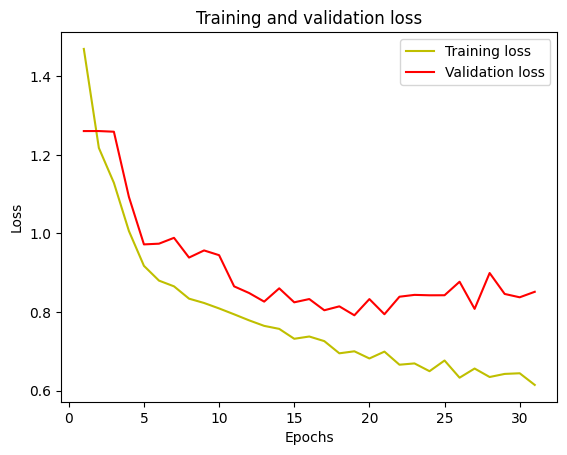

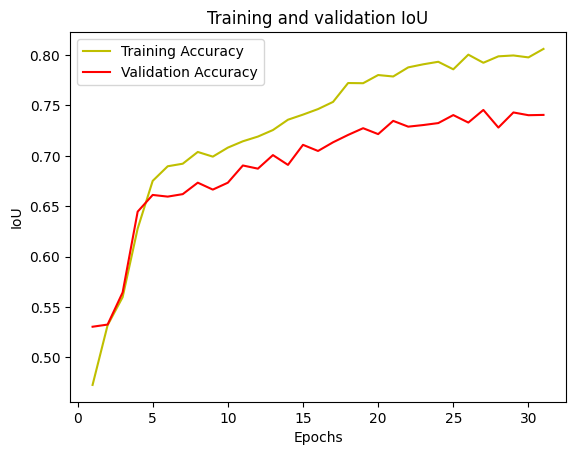

In [ ]:
plot_history(hist)

1/1 [==============================] - 0s 246ms/step


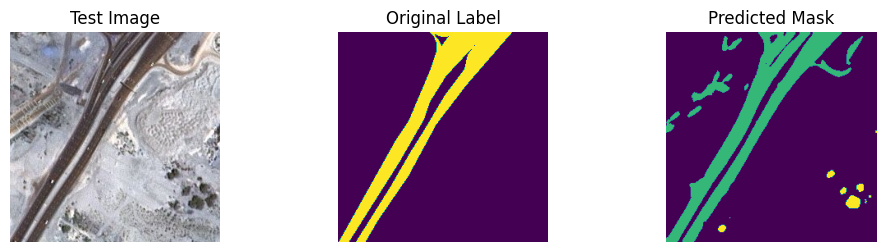

In [ ]:
from keras.models import load_model
import os
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt
root_dir = '/content/drive/MyDrive/1_2_Akshay/satellite_data'


model = load_model('/content/drive/MyDrive/1_2_Akshay/models/Satellite_Image_Segmentation_Multi_UNet_Model.hdf5', compile=False)
test_img_dir = "{}/data/training_data/train_images/train/".format(root_dir)
test_mask_dir = "{}/data/training_data/train_masks/train/".format(root_dir)
imgLst = sorted(os.listdir(test_img_dir))
mskLst = sorted(os.listdir(test_mask_dir))
img_number = random.randint(0, len(imgLst))


def random_prediction():
    ground_truth = cv2.imread(test_mask_dir + '{}'.format(mskLst[img_number]), 0)
    image = cv2.imread(test_img_dir + '{}'.format(imgLst[img_number]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    test_img = (image.reshape(-1, image.shape[-1])).reshape(image.shape)/255.0
    test_img_input = np.expand_dims(test_img, 0)
    prediction = model.predict(test_img_input)
    predicted_img = np.argmax(prediction, axis=3)[0, :, :]
    plt.figure(figsize=(12, 6))

    plt.subplot(231)
    plt.imshow(test_img)
    plt.title('Test Image')
    plt.axis('off')

    plt.subplot(232)
    plt.imshow(ground_truth)
    plt.title('Original Label')
    plt.axis('off')

    plt.subplot(233)
    plt.imshow(predicted_img)
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.show()


random_prediction()

In [ ]:
from keras.models import load_model
import os
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt

root_dir = '/content/drive/MyDrive/1_2_Akshay/satellite_data'

model = load_model('/content/drive/MyDrive/1_2_Akshay/models/Satellite_Image_Segmentation_Simple_UNet_Model.hdf5', compile=False)
test_img_dir = "{}/data/training_data/train_images/train/".format(root_dir)
test_mask_dir = "{}/data/training_data/train_masks/train/".format(root_dir)
imgLst = sorted(os.listdir(test_img_dir))
mskLst = sorted(os.listdir(test_mask_dir))


def predict():
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 20))

    for i, ax in enumerate(axes):
        # Select a random image and its corresponding mask
        img_number = random.randint(0, len(imgLst))

        # Read the ground truth mask and test image
        ground_truth = cv2.imread(test_mask_dir + '{}'.format(mskLst[img_number]), 0)
        image = cv2.imread(test_img_dir + '{}'.format(imgLst[img_number]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Preprocess the test image
        test_img = (image.reshape(-1, image.shape[-1])).reshape(image.shape) / 255.0
        test_img_input = np.expand_dims(test_img, 0)

        # Perform prediction
        prediction = model.predict(test_img_input)
        predicted_img = np.argmax(prediction, axis=3)[0, :, :]

        # Plot the images and masks
        ax[0].imshow(image)
        ax[0].set_title('Test Image')
        ax[0].axis('off')

        ax[1].imshow(ground_truth)
        ax[1].set_title('Original Label')
        ax[1].axis('off')

        ax[2].imshow(predicted_img)
        ax[2].set_title('Predicted Mask')
        ax[2].axis('off')

    plt.tight_layout()
    plt.show()


predict()


Output hidden; open in https://colab.research.google.com to view.

**Multi UNet Prediction**

1/1 [==============================] - 2s 2s/step


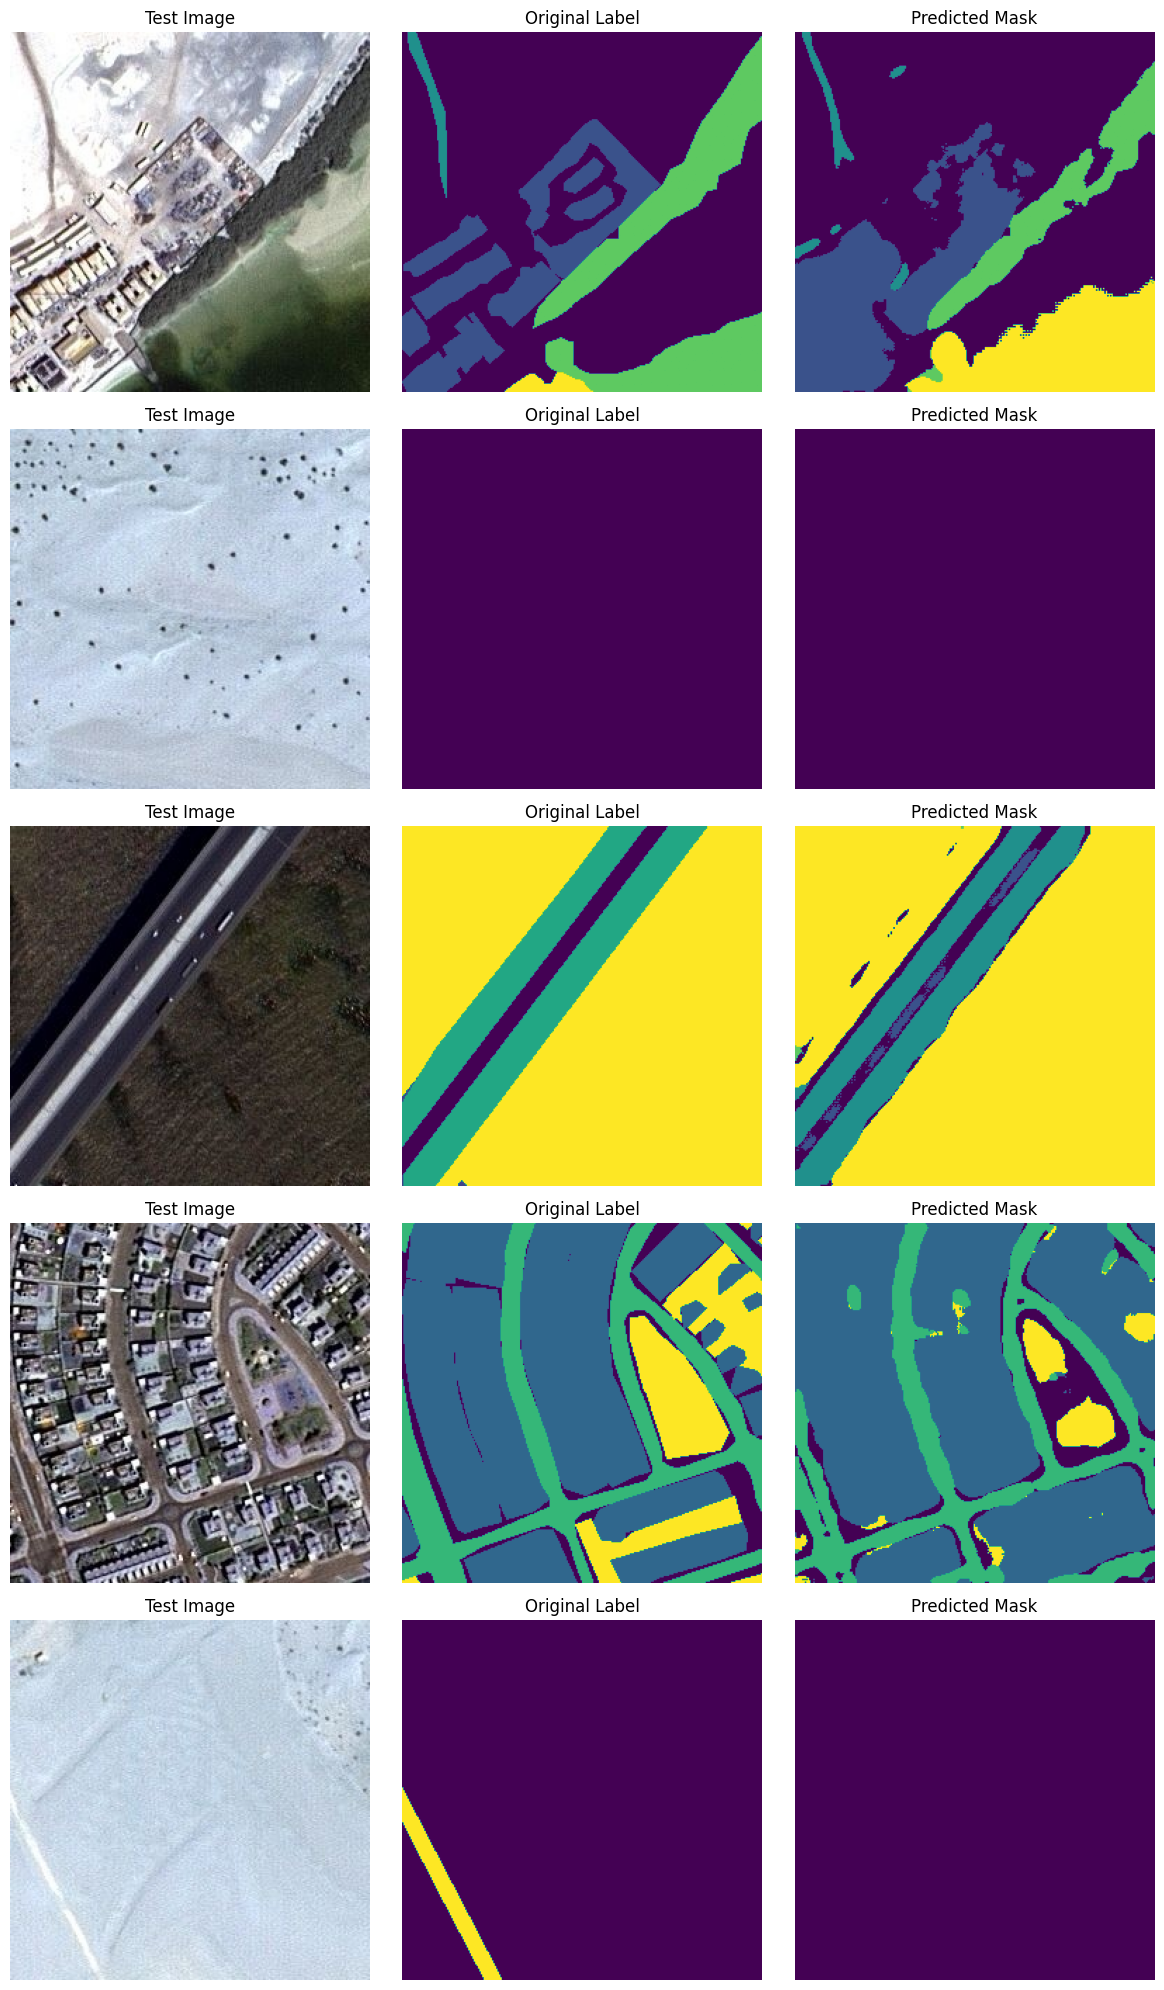

In [ ]:
from keras.models import load_model
import os
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt

root_dir = '/content/drive/MyDrive/1_2_Akshay/satellite_data'

model = load_model('/content/drive/MyDrive/1_2_Akshay/models/Satellite_Image_Segmentation_Multi_UNet_Model.hdf5', compile=False)
test_img_dir = "{}/data/training_data/train_images/train/".format(root_dir)
test_mask_dir = "{}/data/training_data/train_masks/train/".format(root_dir)
imgLst = sorted(os.listdir(test_img_dir))
mskLst = sorted(os.listdir(test_mask_dir))


def predict():
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 20))

    for i, ax in enumerate(axes):
        # Select a random image and its corresponding mask
        img_number = random.randint(0, len(imgLst))

        # Read the ground truth mask and test image
        ground_truth = cv2.imread(test_mask_dir + '{}'.format(mskLst[img_number]), 0)
        image = cv2.imread(test_img_dir + '{}'.format(imgLst[img_number]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Preprocess the test image
        test_img = (image.reshape(-1, image.shape[-1])).reshape(image.shape) / 255.0
        test_img_input = np.expand_dims(test_img, 0)

        # Perform prediction
        prediction = model.predict(test_img_input)
        predicted_img = np.argmax(prediction, axis=3)[0, :, :]

        # Plot the images and masks
        ax[0].imshow(image)
        ax[0].set_title('Test Image')
        ax[0].axis('off')

        ax[1].imshow(ground_truth)
        ax[1].set_title('Original Label')
        ax[1].axis('off')

        ax[2].imshow(predicted_img)
        ax[2].set_title('Predicted Mask')
        ax[2].axis('off')

    plt.tight_layout()
    plt.show()


predict()

1/1 [==============================] - 2s 2s/step


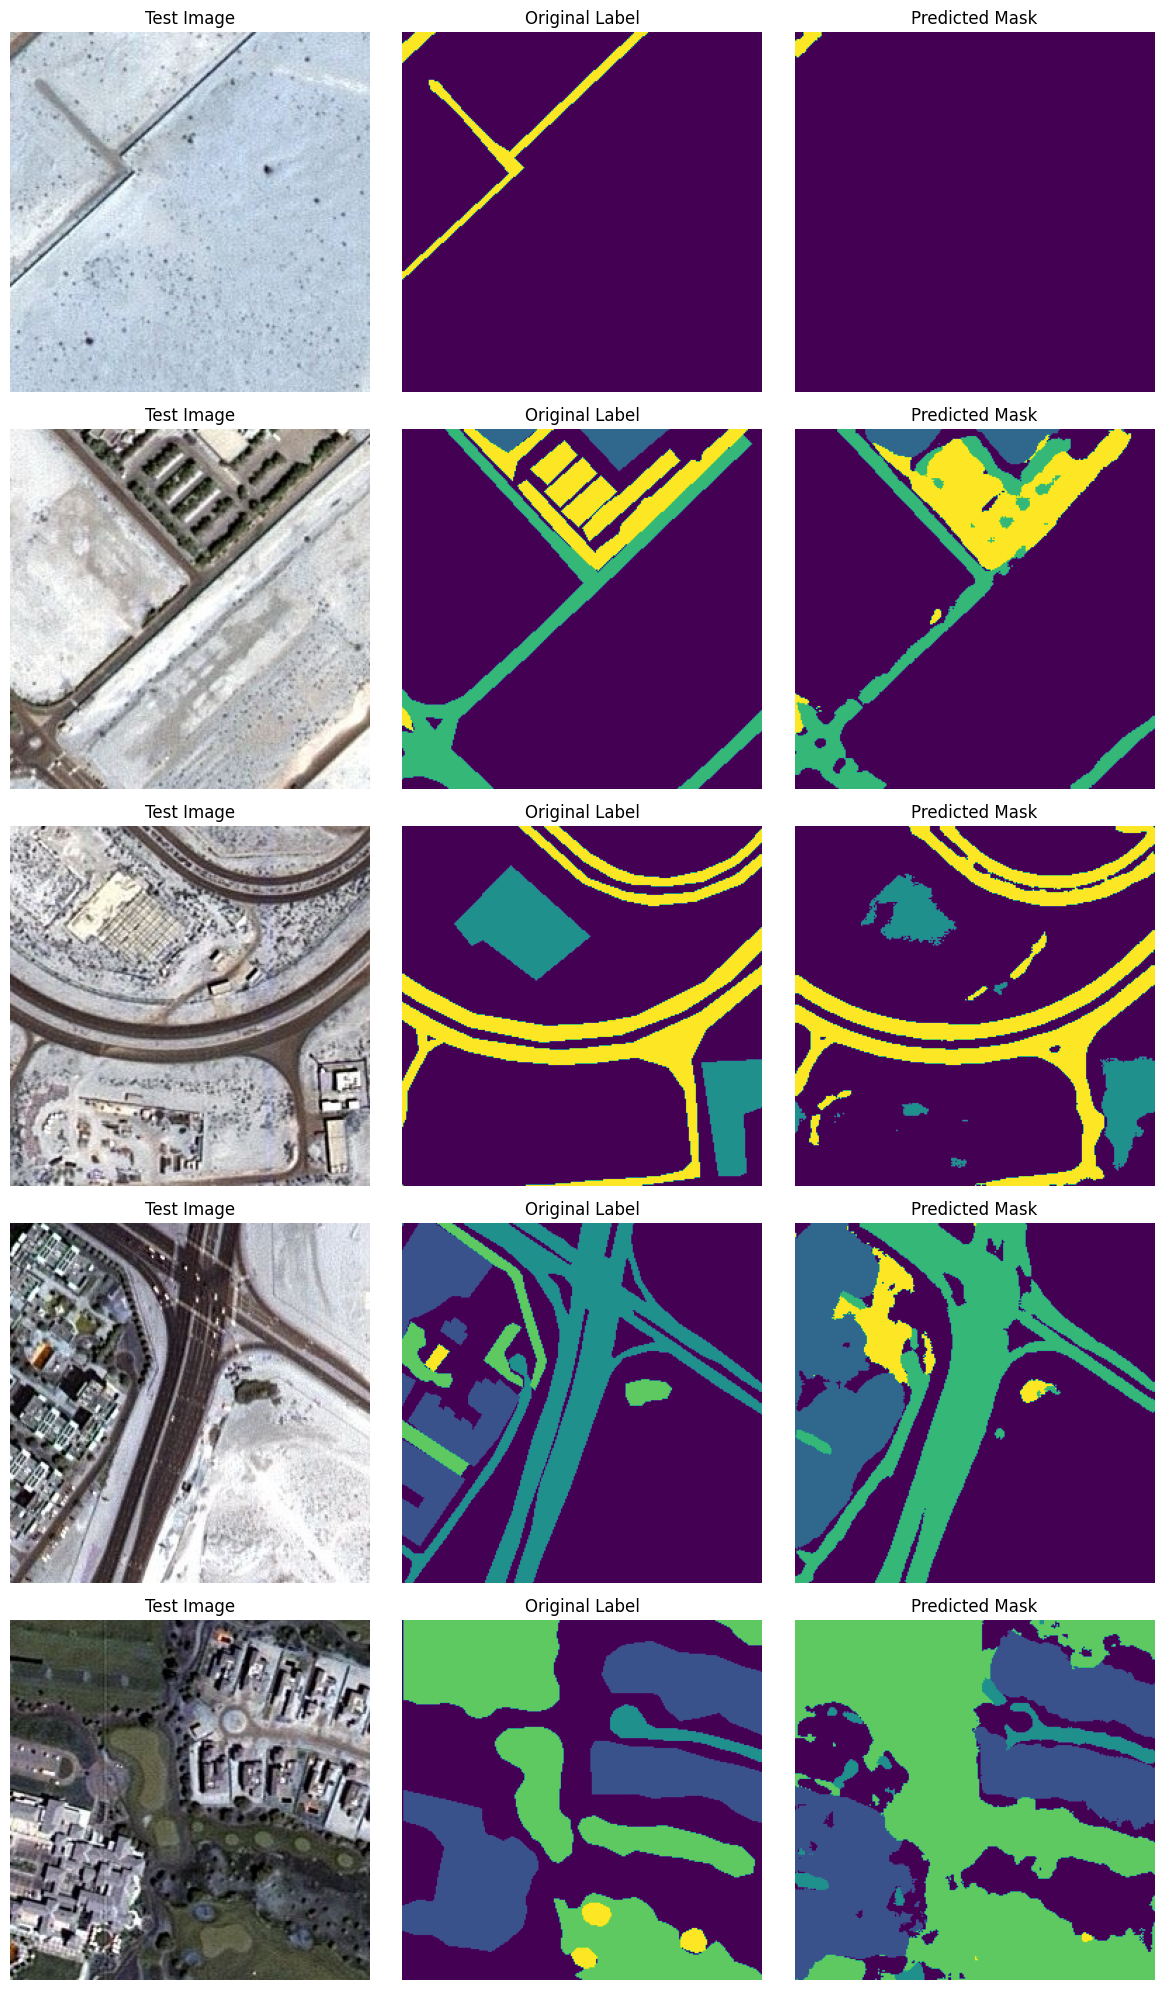

In [ ]:
from keras.models import load_model
import os
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt

root_dir = '/content/drive/MyDrive/1_2_Akshay/satellite_data'

model = load_model('/content/drive/MyDrive/1_2_Akshay/models/Satellite_Image_Segmentation_Multi_UNet_Model.hdf5', compile=False)
test_img_dir = "{}/data/training_data/train_images/train/".format(root_dir)
test_mask_dir = "{}/data/training_data/train_masks/train/".format(root_dir)
imgLst = sorted(os.listdir(test_img_dir))
mskLst = sorted(os.listdir(test_mask_dir))


def predict():
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 20))

    for i, ax in enumerate(axes):
        # Select a random image and its corresponding mask
        img_number = random.randint(0, len(imgLst))

        # Read the ground truth mask and test image
        ground_truth = cv2.imread(test_mask_dir + '{}'.format(mskLst[img_number]), 0)
        image = cv2.imread(test_img_dir + '{}'.format(imgLst[img_number]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Preprocess the test image
        test_img = (image.reshape(-1, image.shape[-1])).reshape(image.shape) / 255.0
        test_img_input = np.expand_dims(test_img, 0)

        # Perform prediction
        prediction = model.predict(test_img_input)
        predicted_img = np.argmax(prediction, axis=3)[0, :, :]

        # Plot the images and masks
        ax[0].imshow(image)
        ax[0].set_title('Test Image')
        ax[0].axis('off')

        ax[1].imshow(ground_truth)
        ax[1].set_title('Original Label')
        ax[1].axis('off')

        ax[2].imshow(predicted_img)
        ax[2].set_title('Predicted Mask')
        ax[2].axis('off')

    plt.tight_layout()
    plt.show()


predict()